# A high-level look at the population of Texas law enforcement sworn officers

In [1]:
OFFICER_INFO_DATASET = ('tji/auxiliary-datasets', 'list_of_texas_officers')

In [2]:
from lib import eda

/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-05-12 23:31:57 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


In [4]:
SAVE_PLOTS = True
PLOT_DIR= '../plots/'
PLOT_PREFIX = 'officer_population_'

# Helper function to (optionally) save and name plots)
plotcount = 0
def saveplot(fig, name):
    if SAVE_PLOTS:
        global plotcount
        plotcount += 1
        filename = os.path.join(PLOT_DIR, PLOT_PREFIX + "%02d_%s.png" % (plotcount, name))
        fig.savefig(filename)

if SAVE_PLOTS:
    prev_plots = [f for f in os.listdir(PLOT_DIR) if f.startswith(PLOT_PREFIX)]
    print("Removing %d past plots" % len(prev_plots))
    for f in prev_plots:
        os.remove(os.path.join(PLOT_DIR, f))


Removing 4 past plots


In [5]:
dataset = dw.load_dataset(OFFICER_INFO_DATASET[0], force_update=True)
officer_info = dataset.dataframes[OFFICER_INFO_DATASET[1]]
officer_info.head()

,name_first,name_middle,name_last,name_suffix,name_full,gender,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time
0,DALE,E,SCHNELLE,NaN,DALE E SCHNELLE,M,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,23.00
1,GARY,D,THOMAS,NaN,GARY D THOMAS,M,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,43.00
2,CHARLES,D,LIGHTFOOT,NaN,CHARLES D LIGHTFOOT,M,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,24.67
3,WILLIAM,R,WATTS,NaN,WILLIAM R WATTS,M,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,23.33
4,KIMBERLY,S,HOLLIDAY,NaN,KIMBERLY S HOLLIDAY,F,ANDERSON CO CONST PCT 3,ANDERSON,MASTER PEACE OFFICER,4,17.33


## Basic population descriptions

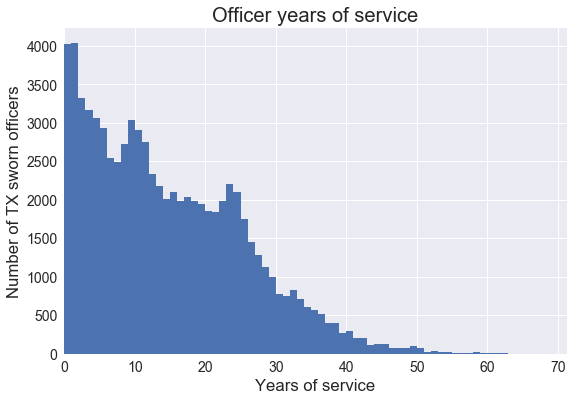

In [6]:
fig, ax = plt.subplots(1)
officer_info.service_time.hist(bins=np.arange(0, 71, 1), ax=ax)
ax.set_title("Officer years of service")
ax.set_xlabel("Years of service")
ax.set_ylabel("Number of TX sworn officers")
ax.set_xlim((0, officer_info.service_time.max()))
saveplot(fig, 'service_years')

In [7]:
officer_info['service_years_int_capped'] = officer_info.service_time.astype(int).apply(lambda y: min(y, 50))

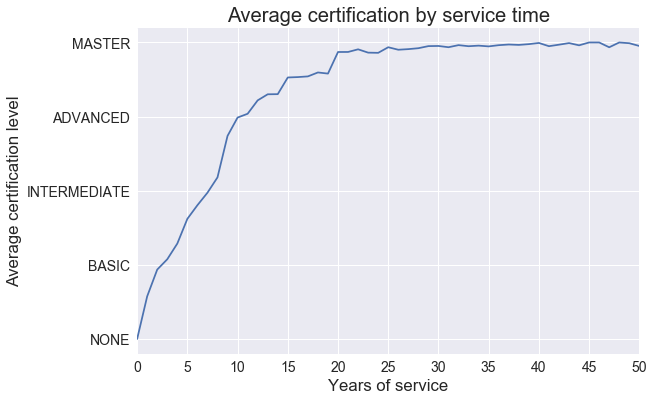

In [8]:
fig, ax = plt.subplots(1)
officer_info.groupby('service_years_int_capped')['highest_cert_int'].mean().sort_index().plot(ax=ax)
ax.set_xlabel('Years of service')
ax.set_xticks(np.arange(0, officer_info['service_years_int_capped'].max() + 5, 5))
ax.set_ylabel('Average certification level')
ax.set_yticks(range(0, 5))
ax.set_yticklabels(['NONE', 'BASIC', 'INTERMEDIATE', 'ADVANCED', 'MASTER'])
ax.set_title('Average certification by service time')
saveplot(fig, 'certification_avg_by_service_years')
pass

In [9]:
cert_levels = {
    'NONE': 0,
    'BASIC PEACE OFFICER': 1,
    'INTERMEDIATE PEACE OFFICER': 2,
    'ADVANCED PEACE OFFICER': 3,
    'MASTER PEACE OFFICER': 4,
}

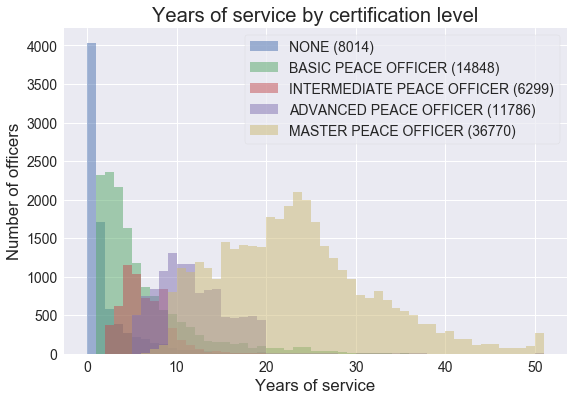

In [10]:
fig, ax = plt.subplots(1)
bins = np.arange(0, 52, 1)
alpha=0.5
for c in cert_levels:
    frame = officer_info[officer_info['highest_cert'] == c]
    frame['service_years_int_capped'].hist(ax=ax, label=c + ' (%d)' % len(frame), alpha=alpha, bins=bins)
ax.legend()
ax.set_title('Years of service by certification level')
ax.set_xlabel('Years of service')
ax.set_ylabel('Number of officers')
saveplot(fig, 'certification_hist_by_service_years')
pass

## More interesting analyses

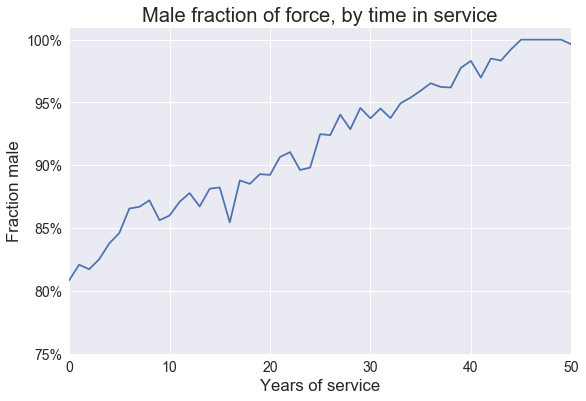

In [11]:
officer_info['is_male'] = officer_info.gender == 'M'
fig, ax = plt.subplots(1)
officer_info.groupby('service_years_int_capped')['is_male'].mean().plot()
ax.set_title('Male fraction of force, by time in service')
ax.set_xlabel('Years of service')
ax.set_ylabel('Fraction male')
ax.set_yticks(np.arange(.75, 1.01, .05))
eda.percentify_y(ax, decimals=0)
saveplot(fig, 'male_fraction_by_service_years')